In [4]:
import numpy as np
import pandas as pd
import os, gc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_transaction_path = "/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv"
train_identity_path = "/content/drive/MyDrive/ieee-fraud-detection/train_identity.csv"

In [47]:
cols_c = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14']
cols_d = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
cols_m = ['M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']     

cols_v = ['V'+str(x) for x in range(1,340)]
types_v = {}
for c in cols_v:
    types_v[c] = 'float32'

train = pd.read_csv(train_transaction_path, usecols=cols_c + cols_d + cols_m + cols_v + ['isFraud'], dtype=types_v)
train.head()

,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Memory Reduction (939Mb -> 505Mb)

In [25]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    print("Original memory usage: {:.2f} Mb".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [26]:
train = reduce_mem_usage(train, verbose = True)

Original memory usage: 939.39
Memory usage decreased to 505.18 Mb (46.2% reduction)


#### Grouping features by NaN Structure:

- If several features have the same number of NaN, they are in the same group.

In [27]:
def capture_nan_struct(df):
    nans_df = df.isna()
    nans_groups={}

    for col in df.columns:
        total_nans = nans_df[col].sum()
        if total_nans in nans_groups:
            nans_groups[total_nans].append(col)
        else:
            nans_groups[total_nans]=[col]

    del nans_df

    for k,v in nans_groups.items():
        print(f'NAN count = {k}')
        print(v)
        print()
    return nans_groups

In [28]:
nans_groups = capture_nan_struct(train)

NAN count = 0
['isFraud', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']

NAN count = 280797
['D2']

NAN count = 262878
['D3']

NAN count = 168922
['D4']

NAN count = 309841
['D5']

NAN count = 517353
['D6']

NAN count = 551623
['D7']

NAN count = 515614
['D8', 'D9']

NAN count = 76022
['D10']

NAN count = 279287
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

NAN count = 525823
['D12']

NAN count = 528588
['D13']

NAN count = 528353
['D14']

NAN count = 89113
['D15']

NAN count = 271100
['M1', 'M2', 'M3']

NAN count = 281444
['M4']

NAN count = 350482
['M5']

NAN count = 169360
['M6']

NAN count = 346265
['M7']

NAN count = 346252
['M8', 'M9']

NAN count = 76073
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V3

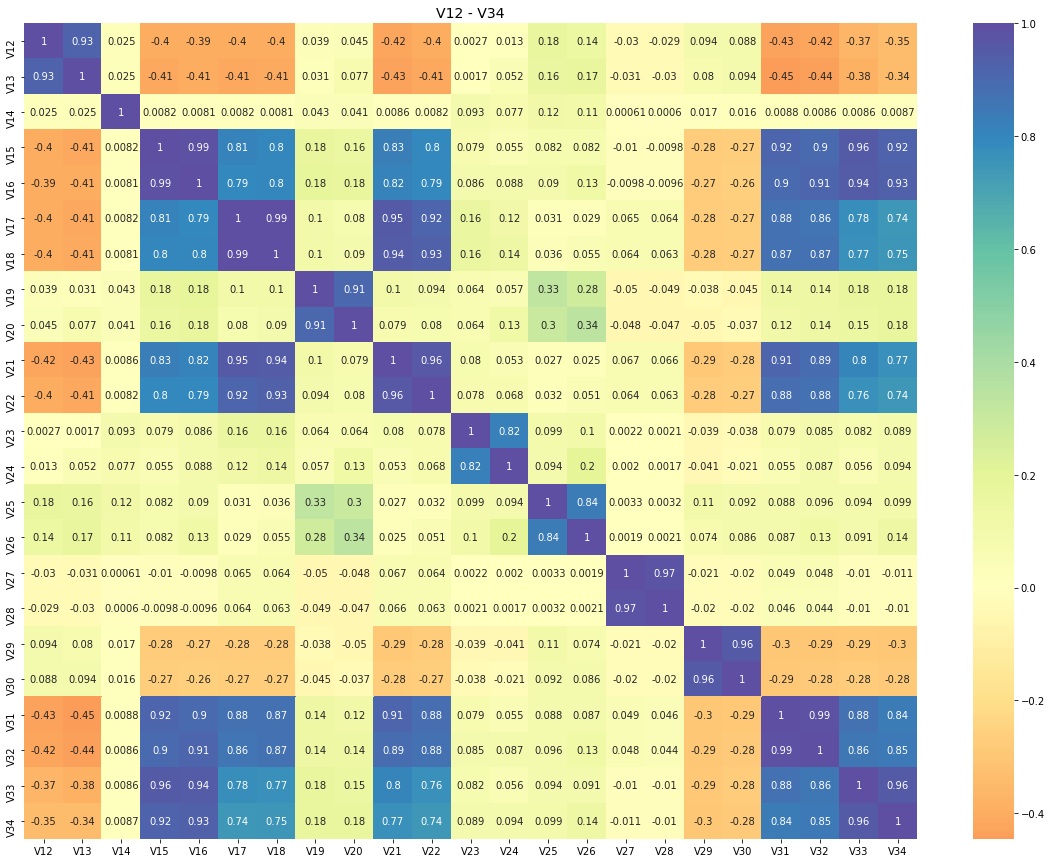

In [50]:
#V12-V34 have the same numeber, visualize their correlation.
def make_corr(cols, Vtitle=''):
    plt.figure(figsize=(20, 15))
    sns.heatmap(train[cols].corr(), cmap='Spectral', annot=True, center=0.0)
    if Vtitle != '': 
        plt.title(Vtitle,fontsize=14)
    else: 
        plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()
    
Vtitle = 'V12 - V34'
make_corr(nans_groups[76073], Vtitle)

### V-Selection logic:
- If two or more features have the same number of NaN and their correlation is greater than 0.7, then we only keep the most informative (having more unique values) one from them.

**Example**:

Here is one group of feature having the same number of NaNs (NaN count = 76073)
:

- **['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']**

After analyzing their correlation with each other, we further group them into:

- ['V12', 'V13'], 
- ['V14'], 
- ['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'],
- ['V19', 'V20'], 
- ['V23', 'V24'], 
- ['V25', 'V26'], 
- ['V27', 'V28'], 
- ['V29', 'V30']

The features within each subgroup share correlation over 0.7 with each other. Then within each subgroup, we choose the feature with the most unique values because it contains the most information and then you remove all the other features from that group. In this example, the final selection will be:

- **['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']**


In [53]:
import numpy as np
from multiprocessing.pool import Pool

def parallel_finding(nans_groups, num_processes):
    all_result = []
    with Pool(num_processes) as pool:
        result = pool.map(find_useful_V, nans_groups)
        all_result += result

    flatten_result = [i for vs in all_result for i in vs if i.startswith("V")]
    return flatten_result

def find_useful_V(V_group):
    already_ingroup = set()
    groups = {}
    for v_i in V_group:
        if v_i not in already_ingroup:
            groups[v_i] = []
            for v_j in V_group:
                if v_j not in already_ingroup:
                    if (train[v_i].dtype != "object") & (train[v_j].dtype != "object"):
                        if np.corrcoef(train[v_i].dropna(), train[v_j].dropna())[1, 0] > 0.7:
                            groups[v_i].append(v_j)
                            already_ingroup.add(v_j)
        else:
            continue
    
    grp_list = [grp for _, grp in groups.items()]
    print(grp_list)
    
    use = []
    for sub_grp in grp_list:
        max_unique = 0
        vx = sub_grp[0]
        for v in sub_grp:
            n = train[v].nunique()
            #print(v, n)
            #select the most informative one
            if n > max_unique:
                max_unique = n
                vx = v
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Only use',use)
    
    return use

In [49]:
%timeit -r 1 -n 1 useful_V = parallel_finding([grp for num_nans, grp in nans_groups.items() if len(grp) > 5 and num_nans > 0], num_processes = 16)

Only use ['V165', 'V160']
Only use ['V332', 'V325', 'V326', 'V335', 'V338']
Only use ['V138', 'V139', 'V142', 'V147', 'V155', 'V162']
Only use ['V220', 'V221', 'V234', 'V238', 'V250', 'V271']
Only use ['D1', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314']
Only use ['D11', 'V1', 'V3', 'V4', 'V6', 'V9', 'V11']
Only use ['V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48']
Only use ['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']
Only use ['V203', 'V207', 'V173', 'V181', 'V192', 'V199', 'V205', 'V216', 'V215']
Only use ['V169', 'V171', 'V174', 'V175', 'V209', 'V185', 'V188', 'V195', 'V198', 'V210']
Only use ['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']
Only use ['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']
Only use ['V307', 'V284', 'V285', 'V286', 'V291', 'V297', 'V303', 'V305', 'V312', 'V310', 'V320']
Only use ['V265', 'V225', 'V264', 'V226', 'V230', 'V240', 'V258', 'V252', 'V262', 'V268', 'V277']
Only use ['V127', 'V98', 'V99', 'V104', 'V107', 'V108', 'V

In [44]:
print('Reduced set has',len(useful_V),'columns')

Reduced set has 122 columns
